# [Computational Social Science] Project 4: Unsupervised Learning

**Enter your Name:** Max Dunsker and Lara Pesce Ares

*Semester:* Fall 2025

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

In [2]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

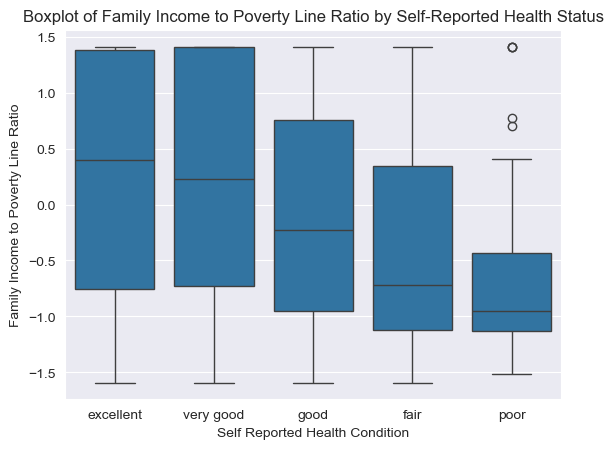

In [3]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])


# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

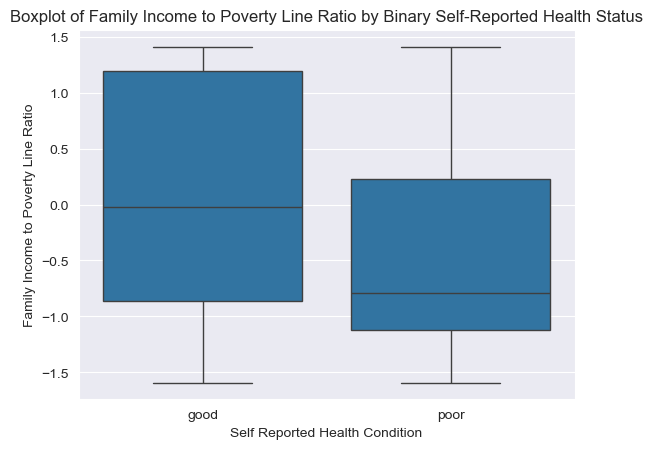

In [4]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

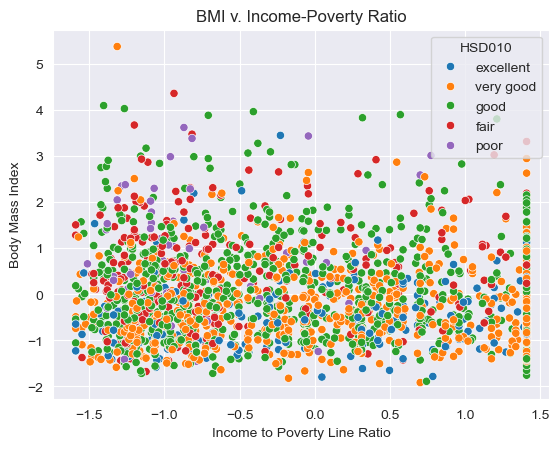

In [5]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again: 

**Note, we create nhanes_X to preserve target variables in nhanes_scaled for later in the lab**

In [6]:
nhanes_X = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)
nhanes_X.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ033,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,-0.680203,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,-0.680203,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,-0.680203,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,-0.680203,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-0.680203,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812


## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following: _(Note, we use nhanes_X)_

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

#### PCA for Barplot Visualization

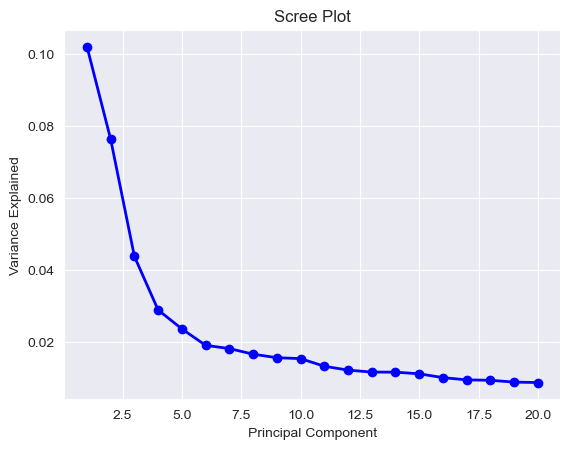

In [7]:
# fit PCA
# ----------
pca_twenty = PCA(20) # after specifying no number of components, used 20 to see where elbow is
principalComponents_nhanes = pca_twenty.fit_transform(nhanes_X)

# create scree plot from PCA fit
# ----------
PC_values = np.arange(pca_twenty.n_components_) + 1
plt.plot(PC_values, pca_twenty.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

### Barplot of Components

For the barplot visualization, I will chose to use 10 principal components. The amount of explained variation falls drastically between components 10 and 11, so I will make a bar plot from the first 10 principal components.

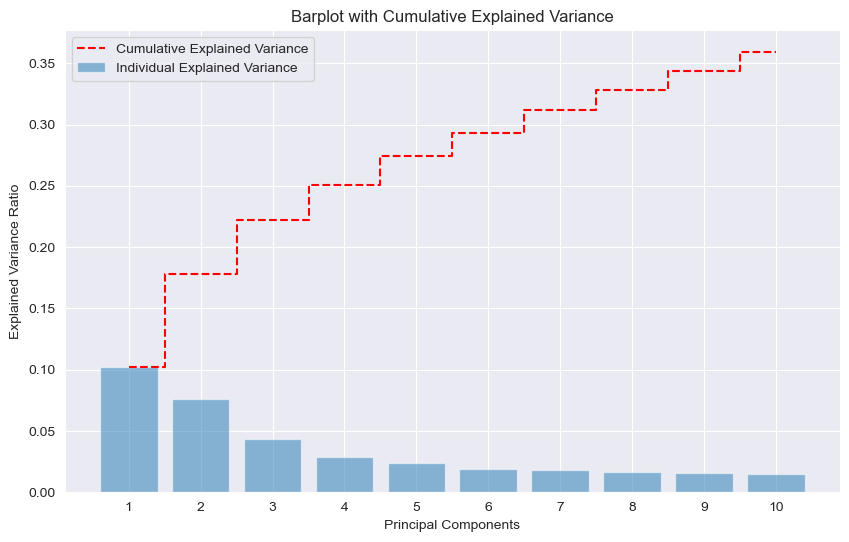

In [8]:
# fit PCA
# ----------
pca_ten = PCA(10) # after specifying no number of components, used 20 to see where elbow is
principalComponents_nhanes = pca_ten.fit_transform(nhanes_X)

# find cumulative variance being explained
# ----------
explained_variance_ratio = pca_ten.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))

# Plot individual explained variance (bar plot)
# ----------
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, align='center', label='Individual Explained Variance')

# Plot cumulative explained variance (line plot)
# ----------
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', color='red', linestyle='--', label='Cumulative Explained Variance')

plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.title('Barplot with Cumulative Explained Variance')
plt.xticks(range(1, len(explained_variance_ratio) + 1)) # Ensure integer ticks on x-axis
plt.legend(loc='best')
plt.grid(True)
plt.show()

### How many components will you use to fit a supervised learning model?

Due to the small amounts of variance explained by each component, I was not able to observe an "elbow" where there was a large drop in explained variance; even when looking at the explained_variance_ratio, there was no visible large drop off. While I would like to select a small amount of principal components, I think it is important that my principal components explain at least 90% of the variance of the dataset based on this source, which says that at least 90% of the variance should be explained if you are using other methods with the PCA results, like clustering (https://support.minitab.com/en-us/minitab/help-and-how-to/statistical-modeling/multivariate/how-to/principal-components/interpret-the-results/key-results/). Based on our barplot of cumulative explained variance, we see the top 10 components only explain <35% of the variance in X, so we will need to inlcude many components to reach our desired treshold in this case.

I tested the requirements to reach several different cumulative explained variance thresholds and observed how they affected our final results, which we discuss further in detail later on. For each of the thresholds, I calculated pca_num to understand the number of components needed to reach that explained variance threshold, which was 120 components for 90%, 145 for 95%, and all 241 for 100%, and ran the subsequent steps. Given our observations, we settled on including 145 components because it was a significant simplification from the full 241, it explained 95% of the variance in X, and it had a positive effect on the accuracy of our final models.

In [9]:
# fit PCA model with no set number of principal components
# ----------
pca_all = PCA()
principalComponents_nhanes = pca_all.fit_transform(nhanes_X)

# find cumulative variance being explained
# ----------
explained_variance_ratio = pca_all.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Find the number of principal components needed to cumulatively explain 95% of the data
# ----------
pca_num = len(np.where(cumulative_variance < .95)[-1]) + 1
print(pca_num)

# fit PCA model with enough PCs to explain 95% of variance
# ----------
pca_fit = PCA(pca_num)
principalComponents_nhanes = pca_fit.fit_transform(nhanes_X)

145


### 2D Scatterplot of the first two components

<Figure size 640x480 with 0 Axes>

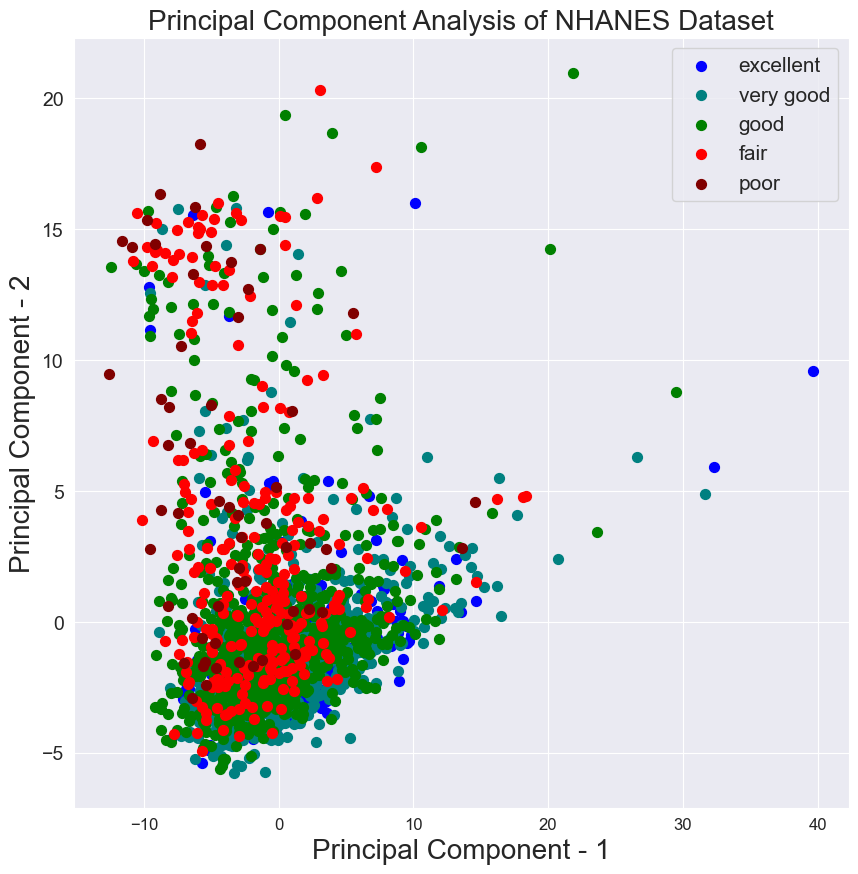

In [10]:
# convert into a dataframe
# ----------
pca_two = pd.DataFrame(data = principalComponents_nhanes[:, 0:2],
                      columns = ['principal component 1', 
                                 'principal component 2'])

# reset index to begin with 0 so that the mask will match up with index of the pca_two dataframe
nhanes_y = pd.DataFrame(nhanes_scaled['HSD010'])
nhanes_y = nhanes_scaled.reset_index()

# bind columns between the dataframe with the first two principal components and the health binary for scatterplot visualization
pca_df = pd.concat([pca_two, nhanes_y], axis=1)

# plot
# ----------

# figure settings
plt.figure();
plt.figure(figsize=(10,10));
plt.xticks(fontsize=12);
plt.yticks(fontsize=14);
plt.xlabel('Principal Component - 1',fontsize=20);
plt.ylabel('Principal Component - 2',fontsize=20);
plt.title("Principal Component Analysis of NHANES Dataset",fontsize=20);
targets = ['excellent', 'very good', 'good', 'fair', 'poor']
colors = ['b', 'teal', 'g', 'r', 'maroon']

# loop over targets and colors to create scatterplot
for target, color in zip(targets,colors):
    indicesToKeep = nhanes_y['HSD010'] == target
    plt.scatter(pca_df.loc[indicesToKeep, 'principal component 1']
               , pca_df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50);

# show figure
plt.legend(targets,prop={'size': 15})
plt.show();

Looking at the scatterplot, most points have a value under 10 in principal component 1 and a value under 5 in principal component 2. Looking both at the binary HSD010 plot (which I did before this version) and the full five category HSD010 plot, there is a lot of overlap among the health categories; the only notable trend is that all of those with a principal component above 20 have "good" health or better, but this is very few observations. The poor separation isn’t too surprising, since PCA is built only from the predictor variables and leaves out our target Y. On top of that, the first two components only capture a modest amount of the overall variation in X, so we shouldn’t expect them to clearly separate the health status groups.

## Clustering

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

I chose to do K-Means clustering, versus agglomerative clustering or DBSCAN, because it appears to work much better on data that has a lot of overlap and is good for large datasets based on the scikit-learn documentation (https://scikit-learn.org/stable/modules/clustering.html). K-Means works by equalizing the variance among the clusters while minimizing the within-cluster sum of squares (or inertia).

In [11]:
# set random seed
np.random.seed(1313)

# plot inertia to understand correct number of clusters
inertias = []
K_range = range(1, 25)  # you can choose any upper bound

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(nhanes_X)
    inertias.append(kmeans.inertia_)   # inertia = within-cluster sum of squares

C:\Users\maxdu\anaconda3\envs\CSS\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
C:\Users\maxdu\anaconda3\envs\CSS\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
C:\Users\maxdu\anaconda3\envs\CSS\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
C:\Users\maxdu\anaconda3\envs\CSS\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is k

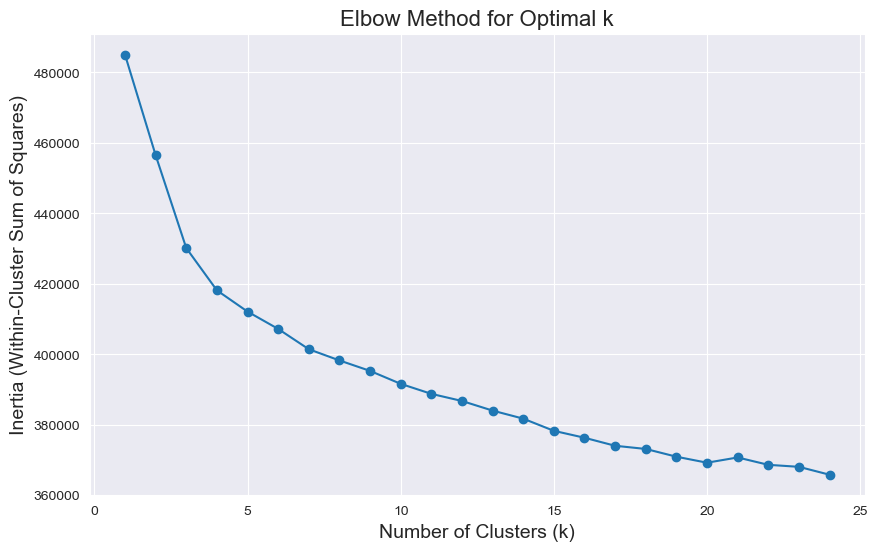

In [12]:
# Plot elbow curve
plt.figure(figsize=(10,6))
plt.plot(K_range, inertias, marker='o')
plt.xlabel('Number of Clusters (k)', fontsize=14)
plt.ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=14)
plt.title('Elbow Method for Optimal k', fontsize=16)
plt.grid(True)
plt.show()

### Cluster nhanes

The elbow chart includes a lot of kinks, with the most notable being at 20 where the inertia actually increases. However, 20 clusters will not be very interpretable. To make the cluster data interpretable, I am choosing to use 7 clusters, as the rate at which the within-cluster sum of squares falls after that point is slightly lower in slope than beforehand, making it the first "elbow".

In [13]:
# specify kmeans algorithm
# ----------
kmeans = KMeans(n_clusters=7,
                random_state = 42,
                n_init=10,
                max_iter=1000000 #made larger to try to improve
                ).fit(nhanes_X)

C:\Users\maxdu\anaconda3\envs\CSS\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

In [14]:
# create numpy array of coordinates needed for scatterplot
plot_data = nhanes_X[['INDFMPIR', 'BMXBMI']].to_numpy()

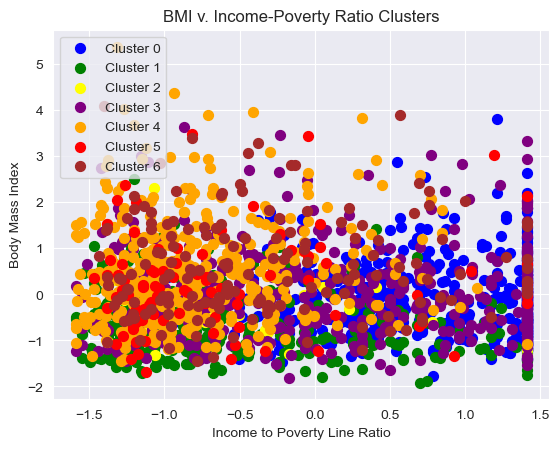

In [15]:
# figure settings
fig = plt.figure()
ax1 = fig.add_subplot(111)

# plot
ax1.scatter(*plot_data[kmeans.labels_==0,:].T, s=50, c='b', label='Cluster 0')
ax1.scatter(*plot_data[kmeans.labels_==1,:].T, s=50, c='g', label='Cluster 1')
ax1.scatter(*plot_data[kmeans.labels_==2,:].T, s=50, c='yellow', label='Cluster 2')
ax1.scatter(*plot_data[kmeans.labels_==3,:].T, s=50, c='purple', label='Cluster 3')
ax1.scatter(*plot_data[kmeans.labels_==4,:].T, s=50, c='orange', label='Cluster 4')
ax1.scatter(*plot_data[kmeans.labels_==5,:].T, s=50, c='r', label='Cluster 5')
ax1.scatter(*plot_data[kmeans.labels_==6,:].T, s=50, c='brown', label='Cluster 6')
#ax1.scatter(*kmeans.cluster_centers_.T, s=50, marker='+', c='black', label='cluster centers') 
# unable to figure out how to plot centers because the dimensions of the dataset are not what 
plt.legend(loc='upper left')
plt.xlabel("Income to Poverty Line Ratio")
plt.ylabel("Body Mass Index")
plt.title("BMI v. Income-Poverty Ratio Clusters")
plt.show()

There is a ton of overlap among the clusters, it does not look like it did a very good job of sorting into clusters along these two axes. However, some patterns do emerge:
 - There seems to be some structure to the data that differentiates by clusters under and above the poverty line, though the distinctions are not clean. This can be seen when observing clusters 3 & 0 vs. 4 & 5
 - While it is diffcult to observe, there does seem to be a little clustering in the lower versus high body mass indeces, like with cluster 2, which has little to no points below -1 BMI
 - There doesn't seem to be a structured relationship between BMI and income borne out in the clusters

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

In [16]:
# specify kmeans algorithm
# ----------
kmeans = KMeans(n_clusters=7, #checked and the optimal k for the PCA was also still 7
                random_state = 42,
                n_init=10,
                max_iter=1000000 #made larger to try to improve
                ).fit(principalComponents_nhanes)

C:\Users\maxdu\anaconda3\envs\CSS\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


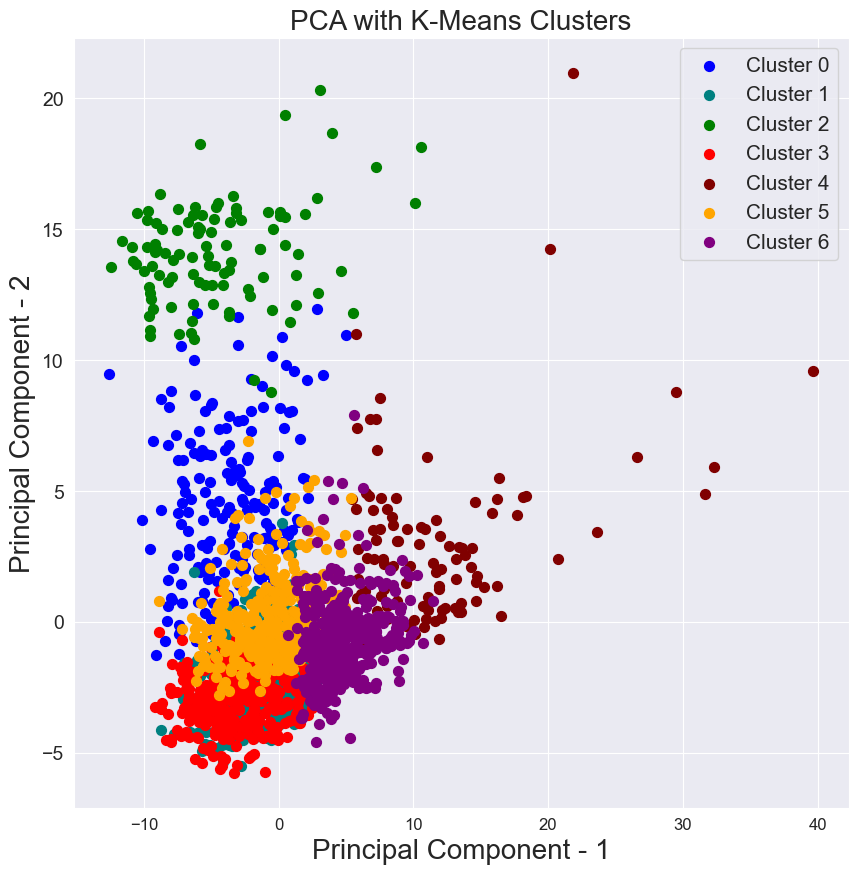

In [17]:
# plot
# ----------

# figure settings
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1', fontsize=20)
plt.ylabel('Principal Component - 2', fontsize=20)
plt.title("PCA with K-Means Clusters", fontsize=20)

colors = ['b', 'teal', 'g', 'r', 'maroon', 'orange',  'purple']
labels = kmeans.labels_

for cluster_id, color in enumerate(colors):
    mask = labels == cluster_id
    plt.scatter(
        pca_df.loc[mask, 'principal component 1'],
        pca_df.loc[mask, 'principal component 2'],
        c=color,
        s=50,
        label=f"Cluster {cluster_id}"
    )

plt.legend(prop={'size': 15})
plt.show()

The clusters show pretty good separation overall and have roughly similar numbers of points, although there is some direct overlap between clusters, which is not surprising for K-means. Most of the clusters are concentrated in the region where principal component 1 is below 10 and principal component 2 is below 5, while the main outliers seem to be captured by clusters 3 and 4.

Comparing this plot to the earlier one where we mapped our target Y (HSD010) onto the top two principal components, the cluster structure in X does not line up very clearly with the health status categories. This suggests that the main variation in X may not be strongly associated with health status and may not be very predictive of it. That said, we are only looking at the first two components, which together explain about 17 percent of the variation in X, so this view may miss patterns from the remaining components.

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [18]:
# partition data
# -----------
y = nhanes_scaled['HSD010_binary'].replace(['good', 'poor'], [1, 0])  # convert hsd010_binary to numeric
X = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1) # drop out columns

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, # chose to do 75/25 there are not that many rows in the data
                                                    random_state = 10)

C:\Users\maxdu\AppData\Local\Temp\ipykernel_5380\2617907605.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = nhanes_scaled['HSD010_binary'].replace(['good', 'poor'], [1, 0])  # convert hsd010_binary to numeric


In [19]:
# load libraries
# -----------
import keras
from keras.utils import to_categorical
keras.utils.set_random_seed(42)

num_classes = 2 # set to 2 because using the binary variable
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
num_classes = y_test.shape[1]
num_classes

2

In [20]:
# convert training data to numpy arrays
x_train = X_train.to_numpy()
x_test = X_test.to_numpy()

# Convert the data type from int to float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# get dimensions of data
num_features = X_train.shape[1]
print(num_features)

241


In [21]:
# create neural network model
# -----------
model = Sequential()

# input layer
model.add(Dense(num_features,           # specify the number of neurons
          input_dim=num_features,       # specify the input shape
          kernel_initializer='normal',  # specify method for initializing weights - follows Gaussian distribution
          activation='relu')            # specify activation function
)

# output layer
model.add(
    Dense(num_classes,                 # specify the number of output units,
          kernel_initializer='normal', # specify method for initializing weights - follows Gaussian distribution
          activation='softmax')        # specify activation function - softmax turns output to probabilities
)

model.compile(loss='categorical_crossentropy',   # specify the loss function
              optimizer='adam',                  # specify optimizer - Adam is an adaptive learning rate optimization algorithm.
              metrics=['accuracy'])              # specify metrics

model.fit(x_train,                  # specify the x data
          y_train,                  # specify the y data
          validation_data=(x_test,  # specify the validation data
                           y_test), 
          epochs=10,                # number of iterations back and forth through the network, 10 was enough to get to limit
          batch_size=500,           # number of rows it will input per batch 
          verbose=2);               # print as it goes (similar to folds in cross validation)

C:\Users\maxdu\anaconda3\envs\CSS\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
4/4 - 3s - 795ms/step - accuracy: 0.4858 - loss: 0.7368 - val_accuracy: 0.7771 - val_loss: 0.5342
Epoch 2/10
4/4 - 0s - 69ms/step - accuracy: 0.8295 - loss: 0.4484 - val_accuracy: 0.8353 - val_loss: 0.4071
Epoch 3/10
4/4 - 0s - 82ms/step - accuracy: 0.8650 - loss: 0.3516 - val_accuracy: 0.8430 - val_loss: 0.3705
Epoch 4/10
4/4 - 0s - 63ms/step - accuracy: 0.8727 - loss: 0.3214 - val_accuracy: 0.8527 - val_loss: 0.3637
Epoch 5/10
4/4 - 0s - 76ms/step - accuracy: 0.8779 - loss: 0.3062 - val_accuracy: 0.8547 - val_loss: 0.3617
Epoch 6/10
4/4 - 0s - 67ms/step - accuracy: 0.8857 - loss: 0.2909 - val_accuracy: 0.8585 - val_loss: 0.3615
Epoch 7/10
4/4 - 0s - 71ms/step - accuracy: 0.8921 - loss: 0.2770 - val_accuracy: 0.8547 - val_loss: 0.3612
Epoch 8/10
4/4 - 0s - 67ms/step - accuracy: 0.8966 - loss: 0.2639 - val_accuracy: 0.8547 - val_loss: 0.3587
Epoch 9/10
4/4 - 0s - 71ms/step - accuracy: 0.9018 - loss: 0.2502 - val_accuracy: 0.8547 - val_loss: 0.3549
Epoch 10/10
4/4 - 0s - 72ms

### Neural Network on Principal Components

In [22]:
# partition data
# -----------
y = nhanes_scaled['HSD010_binary'].replace(['good', 'poor'], [1, 0])  # convert hsd010_binary to numeric

X_train, X_test, y_train, y_test = train_test_split(principalComponents_nhanes, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
num_classes = y_test.shape[1]
num_classes

C:\Users\maxdu\AppData\Local\Temp\ipykernel_5380\2631078017.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = nhanes_scaled['HSD010_binary'].replace(['good', 'poor'], [1, 0])  # convert hsd010_binary to numeric


2

In [23]:
# Convert the data type from int to float
x_train = X_train.astype('float32')
x_test = X_test.astype('float32')

# get dimensions of data
num_features = X_train.shape[1]
print(num_features)

145


In [24]:
# check shape
print(x_train.shape)
print(y_train.shape)

(1548, 145)
(1548, 2)


In [ ]:
# create neural network model
# -----------
model = Sequential()

# input layer
model.add(Dense(num_features,           # specify the number of neurons
          input_dim=num_features,       # specify the input shape
          kernel_initializer='normal',  # specify method for initializing weights - follows Gaussian distribution
          activation='relu')            # specify activation function
)

# output layer
model.add(
    Dense(num_classes,                 # specify the number of output units,
          kernel_initializer='normal', # specify method for initializing weights - follows Gaussian distribution
          activation='softmax')        # specify activation function - softmax turns output to probabilities
)

model.compile(loss='categorical_crossentropy',   # specify the loss function
              optimizer='adam',                  # specify optimizer - Adam is an adaptive learning rate optimization algorithm.
              metrics=['accuracy'])              # specify metrics

model.fit(x_train,                  # specify the x data
          y_train,                  # specify the y data
          validation_data=(x_test,  # specify the validation data
                           y_test), 
          epochs=12,                # number of iterations back and forth through the network, 20 was enough to get to the limit
          batch_size=500,           # number of rows it will input per batch 
          verbose=2);               # print as it goes (similar to folds in cross validation)

Epoch 1/12
4/4 - 2s - 474ms/step - accuracy: 0.6001 - loss: 0.6703 - val_accuracy: 0.8217 - val_loss: 0.5564
Epoch 2/12
4/4 - 0s - 57ms/step - accuracy: 0.8320 - loss: 0.5372 - val_accuracy: 0.8488 - val_loss: 0.4729
Epoch 3/12
4/4 - 0s - 49ms/step - accuracy: 0.8379 - loss: 0.4609 - val_accuracy: 0.8488 - val_loss: 0.4273
Epoch 4/12
4/4 - 0s - 55ms/step - accuracy: 0.8372 - loss: 0.4149 - val_accuracy: 0.8488 - val_loss: 0.4015
Epoch 5/12
4/4 - 0s - 55ms/step - accuracy: 0.8398 - loss: 0.3824 - val_accuracy: 0.8488 - val_loss: 0.3846
Epoch 6/12
4/4 - 0s - 47ms/step - accuracy: 0.8482 - loss: 0.3552 - val_accuracy: 0.8508 - val_loss: 0.3720
Epoch 7/12
4/4 - 0s - 48ms/step - accuracy: 0.8669 - loss: 0.3313 - val_accuracy: 0.8585 - val_loss: 0.3621
Epoch 8/12
4/4 - 0s - 53ms/step - accuracy: 0.8747 - loss: 0.3110 - val_accuracy: 0.8624 - val_loss: 0.3550
Epoch 9/12


### Neural Network on Principal Components + Cluster Membership

In [26]:
# make cluster membership into a column and concatenate it with the PCA numpy array, check shape
print(kmeans.labels_.shape)
print(principalComponents_nhanes.shape)

principalComponents_withLabels_nhanes = np.concatenate((principalComponents_nhanes, kmeans.labels_.reshape(-1, 1)), axis=1)

print(principalComponents_withLabels_nhanes.shape)

(2064,)
(2064, 145)
(2064, 146)


In [27]:
# partition data
# -----------
y = nhanes_scaled['HSD010_binary'].replace(['good', 'poor'], [1, 0])  # convert hsd010_binary to numeric

X_train, X_test, y_train, y_test = train_test_split(principalComponents_withLabels_nhanes, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
num_classes = y_test.shape[1]
num_classes

C:\Users\maxdu\AppData\Local\Temp\ipykernel_5380\2232243565.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = nhanes_scaled['HSD010_binary'].replace(['good', 'poor'], [1, 0])  # convert hsd010_binary to numeric


2

In [28]:
# Convert the data type from int to float
x_train = X_train.astype('float32')
x_test = X_test.astype('float32')

# get dimensions of data
num_features = X_train.shape[1]
print(num_features)

# check shape
print(x_train.shape)
print(y_train.shape)

146
(1548, 146)
(1548, 2)


In [29]:
# create neural network model
# -----------
model = Sequential()

# input layer
model.add(Dense(num_features,           # specify the number of neurons
          input_dim=num_features,       # specify the input shape
          kernel_initializer='normal',  # specify method for initializing weights - follows Gaussian distribution
          activation='relu')            # specify activation function
)

# output layer
model.add(
    Dense(num_classes,                 # specify the number of output units,
          kernel_initializer='normal', # specify method for initializing weights - follows Gaussian distribution
          activation='softmax')        # specify activation function - softmax turns output to probabilities
)

model.compile(loss='categorical_crossentropy',   # specify the loss function
              optimizer='adam',                  # specify optimizer - Adam is an adaptive learning rate optimization algorithm.
              metrics=['accuracy'])              # specify metrics

model.fit(x_train,                  # specify the x data
          y_train,                  # specify the y data
          validation_data=(x_test,  # specify the validation data
                           y_test), 
          epochs=12,                # number of iterations back and forth through the network, 12 was enough to get to the limit
          batch_size=500,           # number of rows it will input per batch 
          verbose=2);               # print as it goes (similar to folds in cross validation)

Epoch 1/12
4/4 - 3s - 676ms/step - accuracy: 0.8146 - loss: 0.5666 - val_accuracy: 0.8527 - val_loss: 0.4832
Epoch 2/12
4/4 - 1s - 192ms/step - accuracy: 0.8372 - loss: 0.4691 - val_accuracy: 0.8508 - val_loss: 0.4313
Epoch 3/12
4/4 - 0s - 51ms/step - accuracy: 0.8379 - loss: 0.4129 - val_accuracy: 0.8488 - val_loss: 0.4023
Epoch 4/12
4/4 - 0s - 52ms/step - accuracy: 0.8411 - loss: 0.3756 - val_accuracy: 0.8527 - val_loss: 0.3840
Epoch 5/12
4/4 - 0s - 51ms/step - accuracy: 0.8527 - loss: 0.3464 - val_accuracy: 0.8488 - val_loss: 0.3704
Epoch 6/12
4/4 - 0s - 49ms/step - accuracy: 0.8656 - loss: 0.3217 - val_accuracy: 0.8566 - val_loss: 0.3597
Epoch 7/12
4/4 - 0s - 48ms/step - accuracy: 0.8798 - loss: 0.3008 - val_accuracy: 0.8566 - val_loss: 0.3519
Epoch 8/12
4/4 - 0s - 60ms/step - accuracy: 0.8902 - loss: 0.2837 - val_accuracy: 0.8702 - val_loss: 0.3470
Epoch 9/12
4/4 - 0s - 63ms/step - accuracy: 0.8947 - loss: 0.2696 - val_accuracy: 0.8721 - val_loss: 0.3443
Epoch 10/12
4/4 - 0s - 103

Full dataset: val_accuracy: 0.8585 - val_loss: 0.3615 (Epoch 6)
PCA components: val_accuracy: 0.8721 - val_loss: 0.3468 (Epoch 20)
PCA components plus clustering: val_accuracy: 0.8721 - val_loss: 0.3443 (Epoch 9)
(note these numbers vary slightly with each execution because it is a neural network)

I went with 12 epochs because it is the point at which we noticed accuracy plateuing. It improved model performance for all without increasing processing time significantly. Increased batch size also improved model performance. 

I would pick PCA components plus clustering, because it gives the highest validation accuracy (0.8624) with no increase in loss relative to PCA alone. It also meaningfully improves over the full-dataset model. Even though the gains are small, this version consistently performs best without any excessive proccessing burden.

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

Both PCA and clustering add structure to deal with variance and complexity in X, completely independently of any Y. PCA adds structure by compressing X into a smaller set of features that capture most of the variation. You use cumulative variance of x explained to select the most reasonable number of components to include. Clustering adds structure by creating a new feature that groups rows/observations together based on how similar they are in the other features. You select the most reasonable number of clusters based on how the "inertia" or within-cluster variation changes as you increase the granularity of the grouping.

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

We tested several thresholds of cumulative variance of x explained by our components starting at 90% to see how they would affect our model performance relative to the full-dataset version.

     - At 100% of X explained, using all 241 principal components, the PCA model performed worse than the full-dataset model, and adding clustering made performance even worse. This makes sense because once the components explain all the variance in X, the clustering step is just adding noise that is unrelated to Y. It is also likely that using all components leads to over-explaining variance in X and hurts generalization compared to versions that use fewer components.
    
     - At 95% explained (using 145 components), the PCA + clustering model did better than PCA alone, and both PCA-based models outperformed the full-dataset model, with PCA + clustering performing best.
    
     - At 90% explained (using 120 components), the PCA-only model performed worse compared to the 95% version and the full dataset, but adding clustering still improved accuracy relative to PCA alone.

We landed on 95% as a midpoint that cuts out some noise and redundancy but still keeps enough structure from X to be predictive. At that level, the PCA and PCA plus clustering models slightly beat the whole-dataset model. The fact that clustering improves the PCA model makes sense because it helps guide the neural network by adding an extra feature that reflects how observations group together in X, without creating too many new columns or injecting a lot of additional noise.

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

Unsupervised techniques can help downstream supervised models by adding structure to X before we re-introduce Y. PCA let us cut the number of input features by more than 100, which directly reduced processing time. This kind of speed-up matters a lot when models are being retrained regularly as part of a pipeline, not just run once. In this case, clustering on top of PCA slightly improved performance compared to PCA alone. 

More generally, unsupervised methods can: 
 - reduce noise in X, which makes it easier for the supervised model to learn useful patterns
 - handle multicollinearity by collapsing groups of highly correlated features into a smaller number of components, which can stabilize training
 - reduce overfitting
 - provide a more interpretable structure for results, for example by revealing meaningful groupings that help us understand and explain what the supervised model is predicting based on.